In [94]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import src.positioning_sensors as ps
import src.regionGrowing as rg
import src.manageExperiments as me
importlib.reload(ps)
importlib.reload(rg)
importlib.reload(me)

import src.network_fitness as netfit
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga

plt.style.use("ggplot")

##
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

#import scipy.misc
#import numpy as np
from skimage.draw import line


In [95]:
fn = "config_exp_13062022.txt"


In [96]:

me.createProject(fn)

creating Directory exp_13062022_flat_is_decrease/
Creating Directory exp_13062022_flat_is_decrease/results/
Creating Directory exp_13062022_flat_is_decrease/semivariances/
Copy config_exp_13062022.txt -> exp_13062022_flat_is_decrease/config_exp_13062022.txt


In [97]:
setup = me.readConfigFile(fn)

In [98]:
flat_means_decrease = bool(setup['flatness_means_decrease'])

In [99]:

#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"]+setup["input_ntli"]
niveles = setup["folder_input"]+setup["input_evm"]

luminance = ps.readIMG(ilumina)

#NTLI: luminance
NTLI = ps.readIMG(ilumina)



In [100]:

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

th = int(setup["desaturation_th"])

In [101]:
nonsat,distance = ps.desaturate(NTLI,th=th)

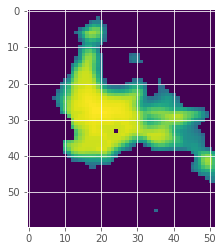

In [102]:


#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y,sigma_x]

nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode=setup['gaussian_mode'])
#nonsat2 = luminance

#we filter only the values greater than 22
nonsat2 = (nonsat2>=setup['neglect_values'])*nonsat2
si = (33,24)
nonsatc = np.copy(nonsat2)
nonsatc[si]=0
plt.imshow(nonsatc)
plt.show()

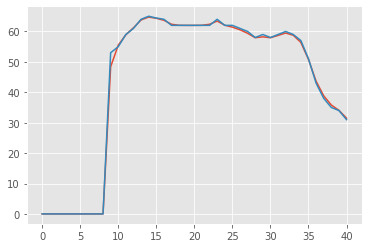

In [103]:
r = 20
plt.plot(nonsat2[si[0],si[1]-r:si[1]+r+1])
plt.plot(nonsat[si[0],si[1]-r:si[1]+r+1])
#plt.vlines(si[1],0,np.max(nonsat2[si[0],:]))


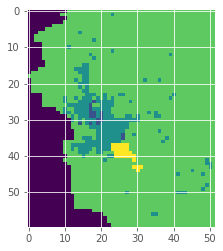

In [104]:
plt.imshow(EAM)

In [105]:
from IPython.display import clear_output

coords = ps.get_coords(nonsat2>0)

#fill the required params
si = (37,18)

params = {"type": "semivar", 
          "si": si, 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(luminance.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(nonsat2)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n,nonsat2.shape[0]*nonsat2.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)

df = pd.DataFrame()

for i,si in enumerate(coords):
    
    clear_output(wait=True)
    s="{percen: 1.2f}%"
    print(s.format(percen = 100*(i+1)/(n)))
    si = tuple(si)
    
    #generate a semivariance sv map
    sv = rG.makeSemivarianceMap(si)
    
    #flattne sv to store it in a dataframe
    allsemivariances[i] = sv.flatten()
    
    #construct a mask of sv and then flatten it
    allmask[i] = ps.constructMask(si,sv,flat_means_decrease).flatten()

 100.00%


In [ ]:
rG.si = si
v = rG.getRegion((33,24))
v[si]=1

In [ ]:
si

(55, 35)

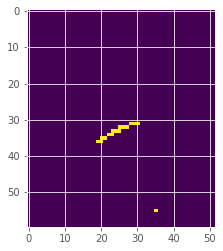

In [108]:
plt.imshow(v)

In [109]:
filesv = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+".csv"
filesvmask = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+"mask.csv"


In [110]:

df_semivariance = pd.DataFrame(allsemivariances)
df_semivariance.insert(0,"coordsy",coords[:,0]) 
df_semivariance.insert(1,"coordsx",coords[:,1])
df_semivariance.to_csv(filesv)

df_semivariance_mask = pd.DataFrame(allmask)
df_semivariance_mask.insert(0,"coordsy",coords[:,0]) 
df_semivariance_mask.insert(1,"coordsx",coords[:,1])
df_semivariance_mask.to_csv(filesvmask)

In [247]:


sv = rG.makeSemivarianceMap(si)

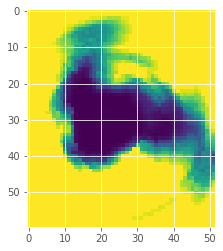

In [248]:
plt.imshow(sv)

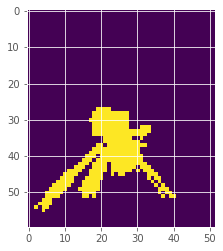

In [249]:
plt.imshow(ps.constructMask(si,sv))

In [77]:
sv[33,24:]

array([0.00000000e+00, 1.39162867e-01, 1.70074725e+00, 6.65967570e+00,
       1.53682726e+01, 2.67228672e+01, 6.90384956e+01, 6.59144411e+01,
       4.22185392e+01, 7.18544844e+01, 8.04448297e+01, 7.23802311e+01,
       4.82005779e+01, 7.79974332e+01, 7.96794817e+01, 9.52580655e+01,
       1.24036635e+02, 2.97241586e+02, 3.41780220e+02, 3.94642639e+02,
       4.21587883e+02, 4.59211007e+02, 4.97001455e+02, 6.08939449e+02,
       8.36514626e+02, 1.14154464e+03, 1.38142291e+03, 1.63511424e+03])

In [66]:
ps.detectRegion([0,1,2,3,4,5,5,5])

5

In [54]:
#cargamos imagenes en luminance e importance
ilumina = 'location/queretaro/qro_light_th'
niveles = 'location/queretaro/prioridades'
sigma_y = 0.5
sigma_x = 0.5
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

In [57]:
nonsat,b = ps.desaturate(luminance,th=setup["desaturation_th"])




#nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
#nonsat2 = (nonsat2>=22)*nonsat2

NLTI = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=setup["neglect_values"])*NLTI